# Sentiment Analysis: Confronto tra Word2Vec (Standard) e GloVe (Twitter)

In questo notebook confronteremo le performance di due diversi embeddings pre-addestrati su un task di sentiment analysis:

1.  **Standard English (Word2Vec/GloVe Wiki)**: Addestrato su testo formale (Wikipedia, News). Ideale per grammatica corretta.
2.  **Social Media (GloVe Twitter)**: Addestrato su tweet. Ideale per recensioni, slang, emoji e testo informale.

La pipeline prevede:
1.  Preprocessing e Creazione del Vocabolario dal Dataset.
2.  Download e caricamento dei modelli pre-addestrati tramite `gensim`.
3.  Creazione delle Matrici di Embedding specifiche per il nostro vocabolario.
4.  Training di due Reti Neurali (identiche nell'architettura) per confrontare i risultati.

In [1]:
# Installazione librerie
!pip install gensim wordcloud matplotlib nltk seaborn torch scikit-learn pandas

  Using cached gensim-4.4.0-cp313-cp313-win_amd64.whl.metadata (8.6 kB)
  Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl.metadata (3.5 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached smart_open-7.5.0-py3-none-any.whl.metadata (24 kB)
  Using cached contourpy-1.3.3-cp313-cp313-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached kiwisolver-1.4.9-cp313-cp313-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
  Using cached wrapt-2.0.1-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
Using cached gensim-4.4.0-cp313-cp313-win_amd64.whl (24.4 MB)
Using cached wordcloud-1.9.4-cp313-cp313-win_amd64.whl (300 kB)
Using cached matplotlib-3.10.8-cp313-cp313-win_amd64.whl (8.1 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached contourpy-1.3.3-cp313-cp313-win_amd


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

nltk.download('punkt')
nltk.download('stopwords')

# Configurazione Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gabs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gabs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Preprocessing e Costruzione Vocabolario Dataset

A differenza del training da zero, qui costruiamo prima il vocabolario basato SOLO sulle parole presenti nel nostro dataset. Successivamente, cercheremo queste parole nei modelli pre-addestrati.

In [3]:
# Caricamento Dati
file_path = '../data/raw/mrev.csv'
df = pd.read_csv(file_path)
df = df[['review_text', 'sentiment']].dropna()

# Map Sentiment
sentiment_map = {label: idx for idx, label in enumerate(df['sentiment'].unique())}
reverse_sentiment_map = {v: k for k, v in sentiment_map.items()}
df['label'] = df['sentiment'].map(sentiment_map)
print("Classi:", sentiment_map)

# Pulizia Testo
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

df['clean_text'] = df['review_text'].apply(clean_text)
df['tokens'] = df['clean_text'].apply(lambda x: x.split())

# Costruzione Vocabolario del Dataset
from collections import Counter
all_words = [word for tokens in df['tokens'] for word in tokens]
word_counts = Counter(all_words)

# Filtriamo parole molto rare per ridurre rumore
min_freq = 2
vocab_list = sorted([k for k, v in word_counts.items() if v >= min_freq])
vocab = {word: i + 1 for i, word in enumerate(vocab_list)} # 0 riservato al padding
vocab_size = len(vocab) + 1

print(f"Dimensione Vocabolario Dataset: {vocab_size}")

Classi: {'Negative': 0, 'Positive': 1, 'Neutral': 2}
Dimensione Vocabolario Dataset: 146


In [4]:
# Preparazione X e y
def text_to_indices(tokens, vocab, max_len=50):
    indices = [vocab[token] for token in tokens if token in vocab]
    if len(indices) < max_len:
        indices += [0] * (max_len - len(indices))
    else:
        indices = indices[:max_len]
    return indices

max_seq_len = 50
X = np.array([text_to_indices(tokens, vocab, max_seq_len) for tokens in df['tokens']])
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# PyTorch Dataset
class ReviewDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_loader = DataLoader(ReviewDataset(X_train, y_train), batch_size=32, shuffle=True)
test_loader = DataLoader(ReviewDataset(X_test, y_test), batch_size=32, shuffle=False)

## 2. Funzioni Core: Matrice dei Pesi e Training

Definiamo funzioni riutilizzabili per estrarre i pesi dai modelli scaricati e per addestrare la rete.

In [5]:
def create_embedding_matrix(target_vocab, pretrained_model, embedding_dim):
    """
    Crea una matrice di pesi filtrando solo le parole presenti nel nostro dataset.
    Se una parola non esiste nel modello pre-addestrato, inizializziamo con random.
    """
    matrix = np.zeros((len(target_vocab) + 1, embedding_dim))
    hits = 0
    misses = 0
    
    for word, idx in target_vocab.items():
        if word in pretrained_model:
            matrix[idx] = pretrained_model[word]
            hits += 1
        else:
            matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
            misses += 1
            
    print(f"Stats Embedding: Trovate {hits} parole, Mancanti {misses} ({misses/(hits+misses):.1%})")
    return matrix

class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_matrix):
        super(SentimentLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # Carichiamo i pesi pre-addestrati
        self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
        self.embedding.weight.requires_grad = False # Freeze iniziale (opzionale, True per fine-tuning)
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim) # *2 per Bidirezionale
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        # Concatena le feature forward e backward
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(self.dropout(hidden))

def train_and_evaluate(embedding_matrix, emb_dim, model_name=" Model"):
    print(f"--- Training {model_name} ---")
    model = SentimentLSTM(vocab_size, emb_dim, 64, len(sentiment_map), embedding_matrix).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    epochs = 10
    history = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_b, y_b in train_loader:
            X_b, y_b = X_b.to(device), y_b.to(device)
            optimizer.zero_grad()
            out = model(X_b)
            loss = criterion(out, y_b)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        # Validation rapida
        model.eval()
        val_preds, val_targets = [], []
        with torch.no_grad():
            for X_b, y_b in test_loader:
                X_b = X_b.to(device)
                out = model(X_b)
                _, preds = torch.max(out, 1)
                val_preds.extend(preds.cpu().numpy())
                val_targets.extend(y_b.numpy())
        
        acc = accuracy_score(val_targets, val_preds)
        history.append(acc)
        print(f"Epoch {epoch+1}: Loss {total_loss/len(train_loader):.4f} | Val Acc: {acc:.4f}")
        
    return history

## 3. Esperimento A: GloVe Wikipedia (Standard English)

Scarichiamo un modello addestrato su Wikipedia (6B tokens). È simile a Word2Vec come tipo di linguaggio.

In [6]:
# NOTA: 'word2vec-google-news-300' è ~1.6GB. Usiamo 'glove-wiki-gigaword-100' (~128MB) per velocità.
# Se vuoi il vero Google News, scommenta la riga sotto:
# model_wiki = api.load("word2vec-google-news-300"); dim_wiki=300

print("Scaricamento GloVe Wiki (può richiedere tempo)... per favore attendi.")
model_wiki = api.load("glove-wiki-gigaword-100")
dim_wiki = 100

matrix_wiki = create_embedding_matrix(vocab, model_wiki, dim_wiki)
hist_wiki = train_and_evaluate(matrix_wiki, dim_wiki, "Standard English (Wiki)")

# Pulizia memoria
del model_wiki

Scaricamento GloVe Wiki (può richiedere tempo)... per favore attendi.
[==================================================] 100.0% 128.1/128.1MB downloaded
Stats Embedding: Trovate 145 parole, Mancanti 0 (0.0%)
--- Training Standard English (Wiki) ---
Epoch 1: Loss 0.0386 | Val Acc: 1.0000
Epoch 2: Loss 0.0002 | Val Acc: 1.0000
Epoch 3: Loss 0.0001 | Val Acc: 1.0000
Epoch 4: Loss 0.0000 | Val Acc: 1.0000
Epoch 5: Loss 0.0000 | Val Acc: 1.0000
Epoch 6: Loss 0.0000 | Val Acc: 1.0000
Epoch 7: Loss 0.0000 | Val Acc: 1.0000
Epoch 8: Loss 0.0000 | Val Acc: 1.0000
Epoch 9: Loss 0.0000 | Val Acc: 1.0000
Epoch 10: Loss 0.0000 | Val Acc: 1.0000


## 4. Esperimento B: GloVe Twitter (Social Media)

Scarichiamo un modello addestrato su 2 miliardi di Tweet. Dovrebbe performare meglio su recensioni informali.

In [7]:
print("Scaricamento GloVe Twitter... per favore attendi.")
model_twitter = api.load("glove-twitter-100")
dim_twitter = 100

matrix_twitter = create_embedding_matrix(vocab, model_twitter, dim_twitter)
hist_twitter = train_and_evaluate(matrix_twitter, dim_twitter, "Social Media (Twitter)")

# Pulizia memoria
del model_twitter

Scaricamento GloVe Twitter... per favore attendi.
[==================================================] 100.0% 387.1/387.1MB downloaded
Stats Embedding: Trovate 145 parole, Mancanti 0 (0.0%)
--- Training Social Media (Twitter) ---
Epoch 1: Loss 0.0406 | Val Acc: 1.0000
Epoch 2: Loss 0.0002 | Val Acc: 1.0000
Epoch 3: Loss 0.0001 | Val Acc: 1.0000
Epoch 4: Loss 0.0000 | Val Acc: 1.0000
Epoch 5: Loss 0.0000 | Val Acc: 1.0000
Epoch 6: Loss 0.0000 | Val Acc: 1.0000
Epoch 7: Loss 0.0000 | Val Acc: 1.0000
Epoch 8: Loss 0.0252 | Val Acc: 1.0000
Epoch 9: Loss 0.0003 | Val Acc: 1.0000
Epoch 10: Loss 0.0001 | Val Acc: 1.0000


## 5. Confronto Finale

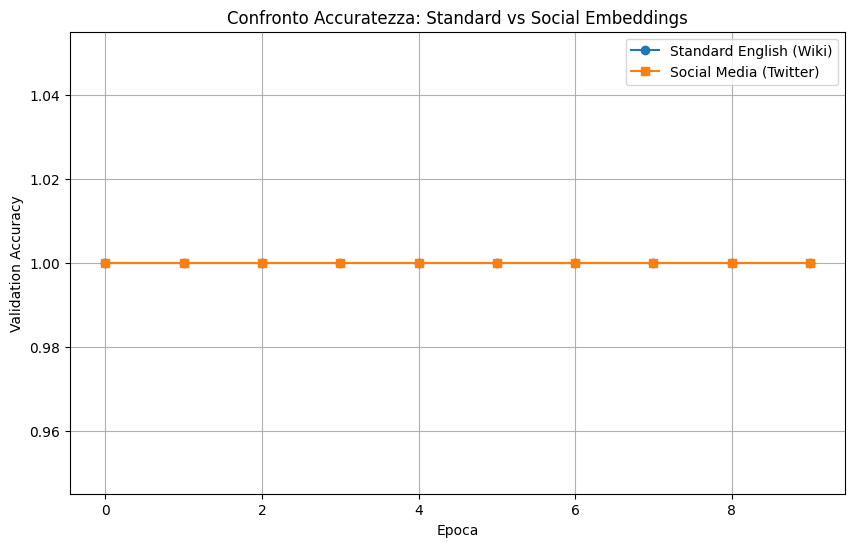

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(hist_wiki, label='Standard English (Wiki)', marker='o')
plt.plot(hist_twitter, label='Social Media (Twitter)', marker='s')
plt.title('Confronto Accuratezza: Standard vs Social Embeddings')
plt.xlabel('Epoca')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()